## Import libraries

In [1]:
##Prerequisite Library to be installed first
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.utils.multiclass import unique_labels

## Download and Load Dataset - MachineLearning/Dataset.csv

In [2]:
! git clone https://github.com/init-sdrb/MachineLearning

Cloning into 'MachineLearning'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 2.50 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
## load dataset as Pandas Dataframe
data_dir = "MachineLearning/Dataset.csv"
# Load the training data
print("- Loading CSV Data -")
df = pd.read_csv(data_dir)
test_url = df['URL_Type_obf_Type'][1]
print("\n### CSV Data Loaded ###\n")

- Loading CSV Data -

### CSV Data Loaded ###



## Summarize the Dataset
- check dimensions of the dataset
- peek at the data
- see the statistical summary of the attributes
- breakdown the data by the class

In [4]:
# dimension of the dataset
df.shape

(36707, 80)

In [5]:
# see all the attributes
df.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

In [6]:
# statistical summary
print(df.describe())

        Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
count  36707.000000        36707.000000      36707.000000       36707.000000   
mean      21.908110            2.857439          8.954668           5.401719   
std       94.280669            0.906562          4.278406           1.986858   
min        0.000000            2.000000          0.000000           1.500000   
25%        0.000000            2.000000          6.000000           4.000000   
50%        0.000000            3.000000          8.000000           5.000000   
75%       19.000000            3.000000         11.000000           6.500000   
max     1385.000000           19.000000         68.000000          29.500000   

       longdomaintokenlen  avgpathtokenlen           tld  charcompvowels  \
count        36707.000000     36427.000000  36707.000000    36707.000000   
mean             9.746016         4.556261      2.857439       14.976517   
std              4.856580         2.839388      0.9

In [7]:
dep_var = 'URL_Type_obf_Type'
print(df.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
Defacement    7930
benign        7781
malware       6712
phishing      7586
spam          6698
dtype: int64


In [8]:
# sample distribution print in markdown table format
label = 'URL_Type_obf_Type'
lblTypes = set(df[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df[df[label] == lbl].index)))

| malware | 6712 |
| phishing | 7586 |
| spam | 6698 |
| Defacement | 7930 |
| benign | 7781 |


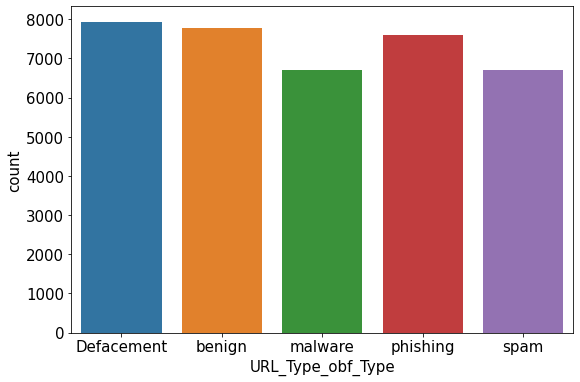

In [9]:
#Visual Representation of label types
fig = plt.figure()
fig.set_size_inches(9, 6)
plt.rcParams.update({'font.size':15})
sns.countplot(x=dep_var,data=df)
plt.show()

print("\nVisual Representation of label type before data clean-up")

## Clean Data
- strip whitespace from column names
- dropped samples/rows with Infinity values
- dropped samples/rows with NaN values

In [10]:
# function loads, cleans and returns panda dataframe
# strip whitespace from column names, drops samples/rows with Infinity and NaN values

def loadAndCleanData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]== 'NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        df['argPathRatio'].astype('float')
        # drop NaN pandas way
        beforeRows = df.shape[0]
        df.dropna(inplace = True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [11]:
df1 = loadAndCleanData('MachineLearning/Dataset.csv')



Dropped 17725 rows with NaN values


In [12]:
print(df1.groupby('URL_Type_obf_Type').size())



URL_Type_obf_Type
Defacement    2477
benign        2709
malware       4440
phishing      4014
spam          5342
dtype: int64


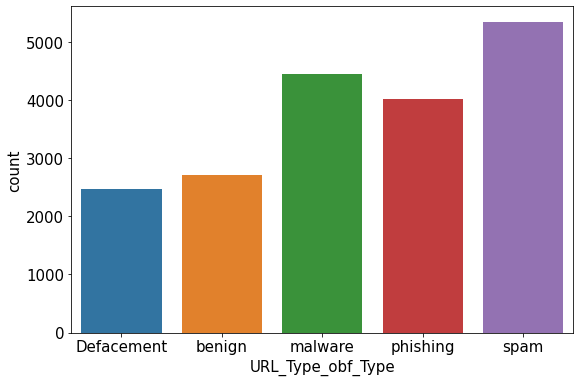


Visual Representation of label type after data clean-up


In [13]:
#Visual Representation of label type after data clean-up
fig = plt.figure()
fig.set_size_inches(9, 6)
plt.rcParams.update({'font.size':15})
sns.countplot(x=dep_var,data=df1)
plt.show()

print("\nVisual Representation of label type after data clean-up")

## Data Visualization
- works better for dataset with fewer features/attributes
- not suited for current dataset with 79 features

## Histogram Plots
  
*    helps understand the distribution of each attribute


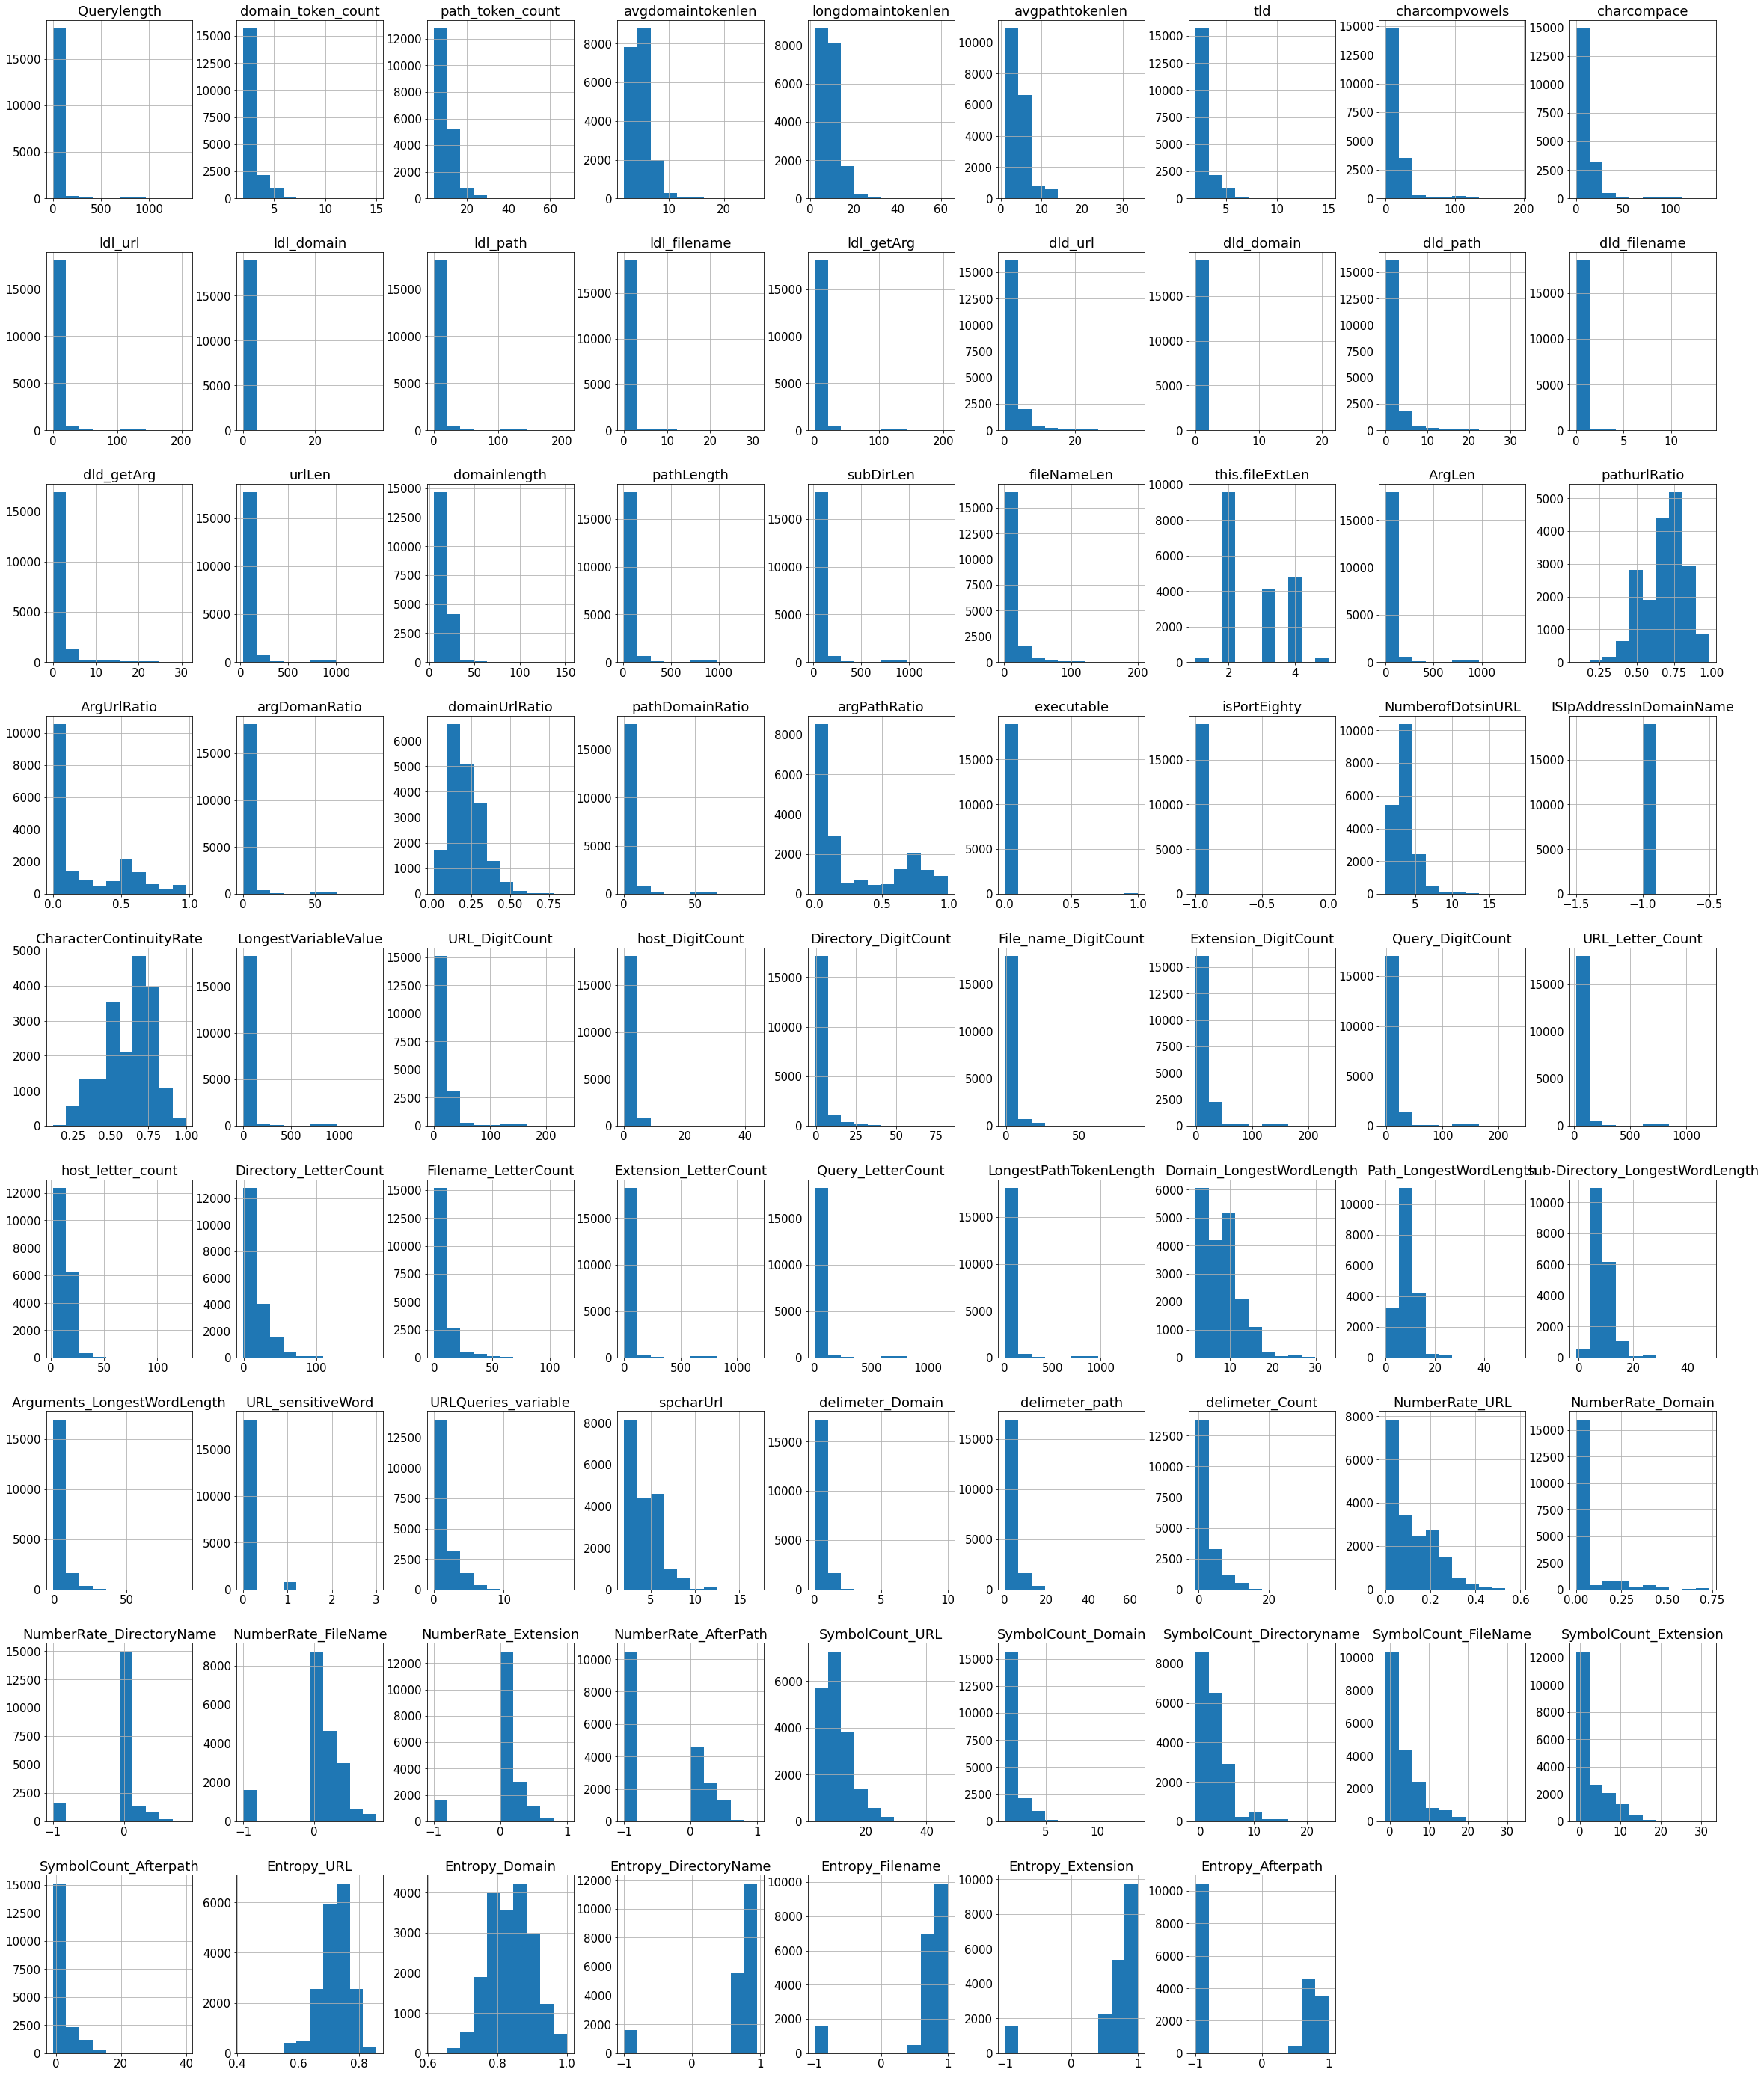

In [17]:
# Histograms of each attribute
df1.hist(figsize=(40, 50))
plt.show()

## Evaluate Traditional ML Algorithms
- create a baseline model from a bunch of traditional ML algorithms
    - separate out a validation dataset
    - set-up test harness to use 10-fold cross-validation
    - build models to classify samples into various URL types
    - select the best model as our baseline model

### Create a Validation Dataset
- will be used to test our model to see how good it is!
- use 80/20 split
- 80% of samples used for training and 20% held back for validation

In [14]:
# Split-out validation dataset
def splitDataset(df):
    array = df.values
    X = array[:,0:79]
    Y = array[:,79]
    validation_size = 0.20
    random_seed = 100
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, 
                                                                                    test_size=validation_size, 
                                                                                    random_state=random_seed)
    return X_train, X_validation, Y_train, Y_validation
    

## Build Models
- build and compare models from 6 traditional machine learning algorithms

## Evaluate Models
- use 10-fold cross validation to estimate accuracy results
- split out dataset into 10 parts, train on 9 and test on 1 and repeat for all combination of train-test splits
- calculate the average accuracy

In [15]:
def runExperiments(X_train, Y_train):
    #random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto')))
    models.append(('AB', AdaBoostClassifier(n_estimators=100)))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))
    models.append(('DT', DecisionTreeClassifier()))


    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=100)
        #kfold = model_selection.KFold(n_splits=10, random_state=random_seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

# Multi-class Classification

In [16]:
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

LR: 0.867040 (0.006360)
LDA: 0.819559 (0.008010)
CART: 0.935726 (0.006013)
KNN: 0.910635 (0.006121)
NB: 0.624104 (0.007902)
SVM: 0.909713 (0.005844)
AB: 0.630163 (0.040048)
RF: 0.962726 (0.005256)
DT: 0.938294 (0.004991)


## Compare and Select Best Model
- Compare Algorithms using box-plot

In [17]:
def compareModels(accuracies, results, classifiers):
    # sort the mean accuracy results in descending order and print
    accuracies.sort(reverse=True)
    for acc, cls in accuracies:
        print("{} {:.2f}".format(cls, acc))
    # Compare Algorithms using box-plot
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(classifiers)
    plt.show()

RF 0.96
DT 0.94
CART 0.94
KNN 0.91
SVM 0.91
LR 0.87
LDA 0.82
AB 0.63
NB 0.62


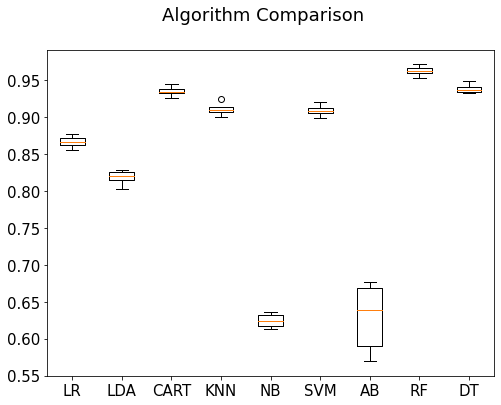

In [18]:
compareModels(accuracies, results, classifiers)

## Make Predictions using Random Forest (RF)

- RF provides superior accuracy result over all the classifiers
- now check the accuracy of the best model using validation set

In [31]:
def testBestModel(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions = rf.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions))
    return Y_predictions

In [32]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.97
Confusion Matrix:
[[ 499    2    2   21    2]
 [   1  531    1   11    2]
 [   1    1  899   11    1]
 [   7   22    7  716   12]
 [   1    1    2   17 1027]]
Classification Report:
              precision    recall  f1-score   support

  Defacement       0.98      0.95      0.96       526
      benign       0.95      0.97      0.96       546
     malware       0.99      0.98      0.99       913
    phishing       0.92      0.94      0.93       764
        spam       0.98      0.98      0.98      1048

    accuracy                           0.97      3797
   macro avg       0.97      0.96      0.96      3797
weighted avg       0.97      0.97      0.97      3797



## Confusion Matrix Visualization

In [120]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

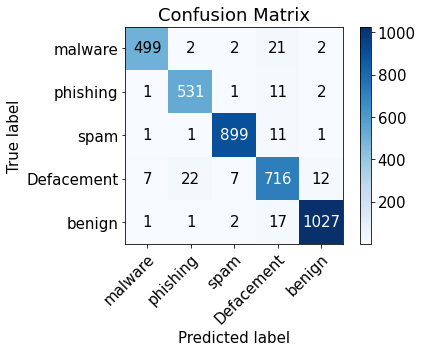

In [121]:
classes = lblTypes
np.set_printoptions(precision=5)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')

# Binary-class classification
- Label spam, phishing, malware, defacement as 'malicious'
- Keep benign type as benign

In [122]:
lblTypes = list(lblTypes)
lblTypes

['malware', 'phishing', 'spam', 'Defacement', 'benign']

In [123]:
lblTypes = dict(zip(lblTypes, ['malicious']*5))
lblTypes['benign'] = 'benign'
lblTypes

{'malware': 'malicious',
 'phishing': 'malicious',
 'spam': 'malicious',
 'Defacement': 'malicious',
 'benign': 'benign'}

In [124]:
df1[label] = df1[label].map(lblTypes)

In [125]:
# class distribution for original data
print(df1.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
benign        2709
malicious    16273
dtype: int64


## Run Experiments to build Models

In [126]:
# NOTE: This takes a long time...
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

LR: 0.953573 (0.005619)
LDA: 0.928482 (0.008264)
CART: 0.980770 (0.002240)
KNN: 0.969509 (0.003104)
NB: 0.612975 (0.009544)
SVM: 0.955087 (0.006536)
AB: 0.979651 (0.002879)
RF: 0.986697 (0.002631)
DT: 0.981363 (0.002671)


## Compare and Select Best Model

RF 0.99
DT 0.98
CART 0.98
AB 0.98
KNN 0.97
SVM 0.96
LR 0.95
LDA 0.93
NB 0.61


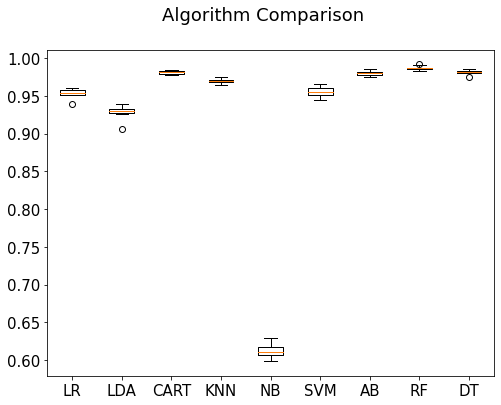

In [127]:
compareModels(accuracies, results, classifiers)

## Make Predictions using Best Classifier: Random Forest (RF)

In [128]:
# train the best model and find the validation accuracy
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions = testBestModel(rf, X_validation, Y_validation)

Accuracy = 0.99
Confusion Matrix:
[[ 531   15]
 [  21 3230]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.97      0.97       546
   malicious       1.00      0.99      0.99      3251

    accuracy                           0.99      3797
   macro avg       0.98      0.98      0.98      3797
weighted avg       0.99      0.99      0.99      3797



### Confusion Matrix Vizualization

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

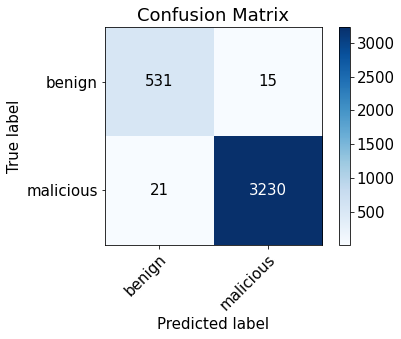

In [129]:
classes = ['benign', 'malicious']
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions, classes=classes, 
                       title='Confusion Matrix')